<a href="https://colab.research.google.com/github/vasudhamanikandan/SYS6016/blob/main/SYS6016_cloud_deploy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras

np.random.seed(49) # note that you must use the same seed to ensure consistentcy in your training/validation/testing
tf.random.set_seed(49)

In [2]:
! pip install -q google-api-python-client
! pip install --upgrade -q google-api-python-client oauth2client

In [3]:
data_dir = "./drive/MyDrive/Indian currency dataset v1"
batch_size = 32;

img_height = 112; 
img_width = 112;


test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(data_dir, 'test'),
    seed = 49,
    image_size = (img_height, img_width),
    batch_size = batch_size
)     

class_names = test_ds.class_names
class_names

Found 91 files belonging to 8 classes.


['10', '100', '20', '200', '2000', '50', '500', 'Background']

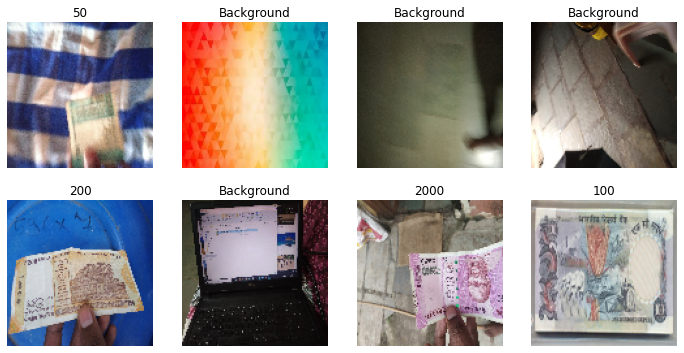

In [4]:
# Visualize some of the train samples of one batch
# Make sure you create the class names that match the order of their appearances in the "files" variable

# Rows and columns are set to fit one training batch (32)
n_rows = 2
n_cols = 4
plt.figure(figsize=(n_cols * 3, n_rows * 3))
for images, labels in test_ds.take(1):
    for i in range (n_rows*n_cols):
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis('off')
        plt.title(class_names[labels[i]], fontsize=12)
plt.subplots_adjust(wspace=.2, hspace=.2)


In [5]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = '/content/drive/MyDrive/modular-bucksaw-312519-3dedeba8d03d.json'

In [6]:
!echo $GOOGLE_APPLICATION_CREDENTIALS

/content/drive/MyDrive/modular-bucksaw-312519-3dedeba8d03d.json


In [7]:
import googleapiclient.discovery
from google.api_core.client_options import ClientOptions

# the service account private key!
# you don't want to paste this into a public notebook...
# os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = '/sfs/qumulo/qhome/js8hh/DR/cloud/cloudStuff/expanded-origin-312503-7148b31fc116.json'

# https://cloud.google.com/ai-platform/prediction/docs/regional-endpoints
endpoint = 'https://us-east4-ml.googleapis.com'
client_options = ClientOptions(api_endpoint=endpoint)
# region could matter 
# Under NaviMenu > AI Platform > Models
# my "Endpoint" is us-east4-ml

# this finds the model_path
ml_resource = googleapiclient.discovery.build("ml", "v1", client_options=client_options, cache_discovery=False).projects()
# https://stackoverflow.com/questions/40154672/importerror-file-cache-is-unavailable-when-using-python-client-for-google-ser
client_options

ClientOptions: {'api_endpoint': 'https://us-east4-ml.googleapis.com', 'client_cert_source': None, 'client_encrypted_cert_source': None, 'quota_project_id': None, 'credentials_file': None, 'scopes': None}

In [8]:
def predict(X):
  input_data_json = {
      "signature_name": "serving_default",
      "instances": X.numpy().tolist()
  }

  class_names = ['10', '100', '20', '200', '2000', '50', '500', 'Background']

  project_id = "modular-bucksaw-312519" # change this to your project ID
  model_id = "currency_model_small" # named in GCP
  model_ver = "v0001" # named in GCP
  # model_path = "projects/{}/models/{}/versions/{}".format(project_id, model_id, model_ver)
  model_path = "projects/{}/models/{}".format(project_id, model_id)

  request = ml_resource.predict(name=model_path, body=input_data_json)
  response = request.execute()

  proba = np.array(response['predictions'])
  class_pred = class_names[np.argmax(proba)]

  return class_pred, proba

def compare_pred(y_hat, y_true):
  print(f"Predicted class: {y_hat}")
  print(f"Actual class: {y_true}")

In [9]:
for images, labels in test_ds.take(1):
  X = images[0]
  y_true = class_names[labels[0]]

X = tf.expand_dims(X, 0)

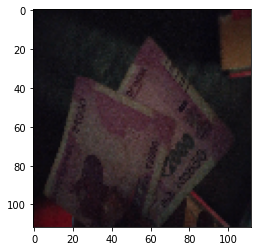

In [10]:
plt.imshow(X[0].numpy().astype("uint8"));

In [11]:
pred = predict(X)
compare_pred(pred[0], y_true)

Predicted class: 2000
Actual class: 2000


In [12]:
project_id = "modular-bucksaw-312519"
model_id = "currency_model_small"
model_path = "projects/{}/models/{}".format(project_id, model_id)

model_request = ml_resource.models().get(name=model_path)
model_response = model_request.execute()
model_response

{'defaultVersion': {'autoScaling': {'minNodes': 1},
  'createTime': '2021-05-02T21:49:55Z',
  'deploymentUri': 'gs://sys6016-currency-model/currencyModelSmall/0001/',
  'description': 'First version',
  'etag': 'bHM+srFuwm8=',
  'framework': 'TENSORFLOW',
  'isDefault': True,
  'machineType': 'n1-standard-4',
  'name': 'projects/modular-bucksaw-312519/models/currency_model_small/versions/v0001',
  'pythonVersion': '3.7',
  'runtimeVersion': '2.4',
  'state': 'READY'},
 'description': 'Takes an input of 112x112 images',
 'etag': '1Ogjf7rQaCY=',
 'name': 'projects/modular-bucksaw-312519/models/currency_model_small',
 'regions': ['us-east4']}